### Table of Contents

* [Chapter 1](#chapter1) Nettoyage des données


## Importation des données

In [1]:
# import des librairies
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats
from sklearn import cluster, metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

## Les figures sont réalisées avec Plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from   plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
path_data='/content/drive/MyDrive/OC_Asma/P07/Data/'

In [4]:
# data = pd.read_csv(path_data+'data.csv',index_col=0)

In [5]:
data_encoded = pd.read_csv(path_data+'data_encoded.csv',index_col=0)
data_encoded.set_index('SK_ID_CURR',inplace = True)

# Préparation des données:

In [6]:
data_1 = data_encoded.drop('TARGET',axis=1)
X = data_1
y = data_encoded['TARGET']
data_1.shape

(307505, 184)

### train, test et validation

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42, stratify=y_test)

In [8]:
print('trainset size:',X_train.shape, y_train.shape,'validset size:',X_val.shape, y_val.shape,'testset size:',X_test.shape, y_test.shape)

trainset size: (184503, 184) (184503,) validset size: (61501, 184) (61501,) testset size: (61501, 184) (61501,)


In [9]:
X_train.to_csv(path_data+"x_train.csv")
y_train.to_csv(path_data+"y_train.csv")
X_val.to_csv(path_data+"x_val.csv")
X_test.to_csv(path_data+"x_test.csv")
y_val.to_csv(path_data+"y_val.csv")
y_test.to_csv(path_data+"y_test.csv")

In [10]:
# % de chaque classe pour les 3 sous groupes( train, test et val)
pd.DataFrame(y_test).value_counts(normalize=True)

TARGET
0         0.91927
1         0.08073
dtype: float64

In [11]:
pd.DataFrame(y_val).value_counts(normalize=True)

TARGET
0         0.91927
1         0.08073
dtype: float64

In [12]:
pd.DataFrame(y_train).value_counts(normalize=True)

TARGET
0         0.91927
1         0.08073
dtype: float64

# Sous et sur echantillonage

In [13]:
# sur-echantillonage:
from sklearn.utils import resample

X_1=X_train

X_1['TARGET']=y_train.values

minority=X_1[X_1['TARGET']==1]
majority=X_1[X_1['TARGET']==0]

minority_upsampled = resample(minority,replace=True,n_samples=len(majority),random_state=42)
upsampled = pd.concat([majority,minority_upsampled])

In [14]:
upsampled

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,...,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
198033,0,1,0,1,0,180000.0,640080.0,31261.5,450000.0,0.072508,-8731,-913.0,-5303.0,-1098,1,1,0,1,1,0,1.0,1,1,12,0,0,0,0,0,0,0.560119,0.510856,0.0,0.0,0.0,0.0,-890.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
428803,0,0,0,1,1,135000.0,432567.0,22779.0,328500.0,0.018029,-10103,-254.0,-1191.0,-1225,1,1,0,1,0,0,3.0,3,3,7,0,0,0,0,0,0,0.554784,0.510856,3.0,1.0,3.0,0.0,-428.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
237022,0,0,0,1,1,112500.0,539100.0,29376.0,450000.0,0.005144,-14401,-3191.0,-6870.0,-1377,1,1,1,1,0,0,3.0,2,2,14,0,0,0,0,0,0,0.603791,0.374021,0.0,0.0,0.0,0.0,-335.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
312069,0,1,1,0,1,216000.0,781920.0,39924.0,675000.0,0.002506,-12845,-1574.0,-1613.0,-1645,1,1,1,1,1,0,3.0,2,2,0,0,0,0,0,0,0,0.668384,0.456110,1.0,0.0,1.0,0.0,-1004.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
245972,0,0,0,1,1,135000.0,167121.0,11097.0,139500.0,0.007305,-11639,-139.0,-5081.0,-2581,1,1,0,1,0,0,2.0,3,3,11,0,0,0,0,0,0,0.528323,0.504681,0.0,0.0,0.0,0.0,-406.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347974,0,0,1,1,0,202500.0,550980.0,43528.5,450000.0,0.009630,-12860,-3911.0,-168.0,-445,1,1,0,1,0,0,1.0,2,2,13,0,0,0,0,0,0,0.529805,0.427657,3.0,0.0,3.0,0.0,-1756.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
215421,0,1,0,1,0,243000.0,675000.0,32602.5,675000.0,0.018209,-20547,-1535.0,-5471.0,-2854,1,1,0,1,0,0,1

In [15]:
# % équilibré des deux classes
upsampled['TARGET'].value_counts(normalize=True)

1    0.5
0    0.5
Name: TARGET, dtype: float64

In [16]:
X_train_up=upsampled.drop('TARGET',axis=1)
y_train_up=upsampled['TARGET']

In [17]:
# Sous-echantillonage:

majority_dowsampled = resample(majority,replace=False,n_samples=len(minority),random_state=42)
downsampled = pd.concat([minority,majority_dowsampled])

In [18]:
downsampled

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,...,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
103477,0,0,0,1,0,58500.0,157050.0,8649.0,112500.0,0.020246,-11155,-971.000000,-11116.0,-1796,1,1,0,1,0,0,2.0,3,3,10,0,0,0,0,0,0,0.022155,0.340906,5.0,1.0,5.0,1.0,-676.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
168051,0,0,0,0,0,135000.0,1096020.0,52857.0,900000.0,0.035792,-10302,-1588.000000,-3669.0,-658,1,1,1,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.707796,0.510856,0.0,0.0,0.0,0.0,-467.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
182249,0,1,1,1,0,157500.0,490536.0,22995.0,405000.0,0.031329,-9810,-578.000000,-9783.0,-2502,1,1,0,1,0,1,1.0,2,2,7,0,0,0,0,1,1,0.633105,0.297087,2.0,0.0,2.0,0.0,-23.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
243429,0,1,0,1,0,202500.0,779688.0,37638.0,630000.0,0.010500,-12698,-777.000000,-5904.0,-4431,1,1,0,1,0,0,2.0,3,3,11,0,0,0,1,1,0,0.713466,0.408359,2.0,1.0,2.0,1.0,-1743.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
200687,0,0,0,1,0,157500.0,119925.0,14359.5,112500.0,0.018029,-15629,-8423.000000,-8658.0,-4186,1,1,1,1,0,0,2.0,3,3,11,0,0,0,0,0,0,0.475606,0.207964,0.0,0.0,0.0,0.0,-1654.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305895,0,0,1,0,0,193500.0,508495.5,21672.0,454500.0,0.014464,-20546,-2384.155641,-852.0,-771,1,0,0,1,1,0,2.0,2,2,7,0,0,0,0,0,0,0.323824,0.347418,0.0,0.0,0.0,0.0,-14.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
426360,0,0,0,1,0,157500.0,435253.5,21298.5,306000.0,0.019689,-9515,-372.0000

In [19]:
# % équilibré des deux classes:
downsampled['TARGET'].value_counts(normalize=True)

1    0.5
0    0.5
Name: TARGET, dtype: float64

In [20]:
X_train_down=downsampled.drop('TARGET',axis=1)
y_train_down=downsampled['TARGET']

In [21]:
import imblearn
print(imblearn.__version__)

0.8.1


In [22]:
X_train=X_train_up
y_train= y_train_up

In [23]:
# # Normalisation des données:


# from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(X_train.values)
# X_train = pd.DataFrame(x_scaled,columns=data_1.columns)

# X_val=min_max_scaler.fit_transform(X_val.values)
# X_val = pd.DataFrame(X_val,columns=data_1.columns)

# X_test=min_max_scaler.fit_transform(X_test.values)
# X_test = pd.DataFrame(X_test,columns=data_1.columns)



### Réduire les features 

In [24]:
# selectionner la meillieure variable:
reg_rf = RandomForestClassifier(n_estimators=100,oob_score=True, random_state=42)
reg_rf.fit(X_train, y_train)
y_pred_rf = reg_rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [25]:
# !pip install shap

In [26]:
# import shap

In [27]:
# subset_to_explain = X_test
# explainer = shap.TreeExplainer(reg_rf, subset_to_explain)
# shap_values = explainer.shap_values(subset_to_explain)
# shap.initjs()
# shap.summary_plot(shap_values, subset_to_explain,feature_names=features)

In [28]:
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       0.45      0.01      0.02      4965

    accuracy                           0.92     61501
   macro avg       0.69      0.50      0.49     61501
weighted avg       0.88      0.92      0.88     61501



In [29]:
print("roc_auc_score: ", roc_auc_score(y_test, y_pred_rf))
print("f1 score rf: ", f1_score(y_test, y_pred_rf))
print("accuracy_score",accuracy_score(y_test, y_pred_rf))

roc_auc_score:  0.5045046113797004
f1 score rf:  0.019704433497536946
accuracy_score 0.91910700639014


In [30]:
feature_imp = pd.DataFrame({'Features': data_1.columns ,'Importance':reg_rf.feature_importances_ }).sort_values('Importance', ascending=False)
print(feature_imp)

                            Features    Importance
30                      EXT_SOURCE_2  6.919144e-02
31                      EXT_SOURCE_3  6.802791e-02
67           CREDIT_TO_ANNUITY_RATIO  3.642978e-02
10                        DAYS_BIRTH  3.616892e-02
63          PROPORTION_LIFE_EMPLOYED  3.568851e-02
..                               ...           ...
14                        FLAG_MOBIL  2.219892e-07
47                  FLAG_DOCUMENT_12  1.968734e-07
77      NAME_INCOME_TYPE_Businessman  0.000000e+00
79  NAME_INCOME_TYPE_Maternity leave  0.000000e+00
45                  FLAG_DOCUMENT_10  0.000000e+00

[184 rows x 2 columns]


In [31]:
seuil_imp=0.007
feature_selected=feature_imp[feature_imp['Importance']>seuil_imp]
len(feature_selected)

25

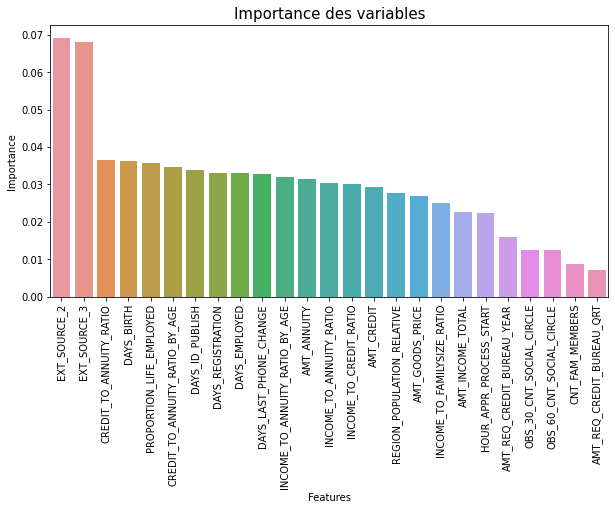

In [32]:
plt.figure(figsize=(10, 5))
plt.title('Importance des variables', size=15)
plot = sns.barplot(x = feature_selected['Features'], y=feature_selected['Importance'])
plt.xticks(rotation = 'vertical')
plt.show()

In [33]:
feature_selected_list=feature_selected['Features'].tolist()

In [34]:
X_train=X_train[feature_selected_list]
X_val=X_val[feature_selected_list]
X_test=X_test[feature_selected_list]

# Modélisation

### Sur echantillonage

In [35]:
X_train

,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_TO_ANNUITY_RATIO,DAYS_BIRTH,PROPORTION_LIFE_EMPLOYED,CREDIT_TO_ANNUITY_RATIO_BY_AGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_EMPLOYED,DAYS_LAST_PHONE_CHANGE,INCOME_TO_ANNUITY_RATIO_BY_AGE,AMT_ANNUITY,INCOME_TO_ANNUITY_RATIO,INCOME_TO_CREDIT_RATIO,AMT_CREDIT,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,INCOME_TO_FAMILYSIZE_RATIO,AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START,AMT_REQ_CREDIT_BUREAU_YEAR,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,CNT_FAM_MEMBERS,AMT_REQ_CREDIT_BUREAU_QRT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,
198033,0.560119,0.510856,20.475025,-8731,0.104570,-178767.444940,-1098,-5303.0,-913.0,-890.0,-50272.059882,31261.5,5.757881,0.281215,640080.0,0.072508,450000.0,180000.0,180000.0,12,1.899954,0.0,0.0,1.0,0.265475
428803,0.554784,0.510856,18.989727,-10103,0.025141,-191853.215725,-1225,-1191.0,-254.0,-428.0,-59875.543264,22779.0,5.926511,0.312090,432567.0,0.018029,328500.0,45000.0,135000.0,7,1.899954,3.0,3.0,3.0,0.265475
237022,0.603791,0.374021,18.351716,-14401,0.221582,-264283.057598,-1377,-6870.0,-3191.0,-335.0,-55150.888480,29376.0,3.829657,0.208681,539100.0,0.005144,450000.0,37500.0,112500.0,14,2.000000,0.0,0.0,3.0,2.000000
312069,0.668384,0.456110,19.585212,-12845,0.122538,-251572.046889,-1645,-1613.0,-1574.0,-1004.0,-69495.040577,39924.0,5.410280,0.276243,781920.0,0.002506,675000.0,72000.0,216000.0,0,2.000000,1.0,1.0,3.0,0.000000
245972,0.528323,0.504681,15.060016,-11639,0.011943,-175283.528792,-2581,-5081.0,-139.0,-406.0,-141593.673966,11097.0,12.165450,0.807798,167121.0,0.007305,139500.0,67500.0,135000.0,11,0.000000,0.0,0.0,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347974,0.529805,0.427657,12.657914,-12860,0.304121,-162780.771219,-445,-168.0,-3911.0,-1756.0,-59826.320686,43528.5,4.652124,0.367527,550980.0,0.009630,450000.0,202500.0,202500.0,13,7.000000,3.0,3.0,1.0,0.000000
215421,0.384991,0.597192,20.703934,-20547,0.074707,-425403.726708,-2854,-5471.0,-1535.0,-1444.0,-153145.341615,32602.5,7.453416,0.360000,675000.0,0.018209,675000.0,243000.0,243000.0,11,0.000000,1.0,1.0,1.0,0.000000
365908,0.606075,0.180888,13.798813,-13836,0.092368,-190920.380847,-4453,-1704.0,-1278.0,-2990.0,-57276.114254,32611.5,4.139644,0.300000,450000.0,0.035792,450000.0,45000.0,135000.0,12,3.000000,1.0,1.0,3.0,0.000000


In [36]:
X_train_s1, X_train_s2, y_train_s1, y_train_s2 = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, stratify=y_train)

In [37]:
# Dictionnaire de classifieurs 
classifiers_1 = { 'Logistic Regression': LogisticRegression(),
                  'Random Forest': RandomForestClassifier(n_estimators=100),
                  'Xgboost': XGBClassifier(),
                  'LGBM': LGBMClassifier()
              }

In [38]:
# Pipeline de standardisation et d'imputation des valeurs manquantes
# def define_pipeline(classifier) :
#   var_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
#                          ('echantillonage',SMOTE(random_state=42)),
#       ('scaler', RobustScaler()),
#       ("regressor", classifier),
# ])

In [39]:
# Pipeline de transformations + classification
def define_pipeline(classifier) :
    
    pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('echantillonage',SMOTE(random_state=42)),
                     ('scaler', RobustScaler()),
                     ("regressor", classifier),
                    ])
    return pipe

In [40]:
def plot_roc_curve(classifiers, X, y, n_splits=5, fit=True):

    kf = KFold(n_splits=n_splits, shuffle=True,random_state=42)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):
          

            full_pipeline = define_pipeline(clf)
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

Random Forest
Xgboost
LGBM


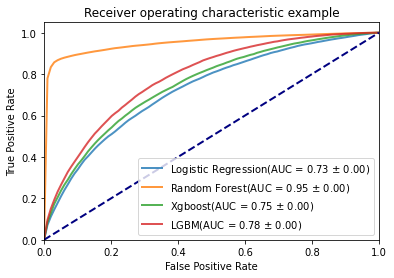

In [41]:
plot_roc_curve(classifiers_1, X_train_s2, y_train_s2)

### Sous echantillonage

In [42]:
X_train=X_train_down
y_train= y_train_down

In [43]:
X_train=X_train[feature_selected_list]

In [44]:
X_train_s1, X_train_s2, y_train_s1, y_train_s2 = train_test_split(X_train, y_train, test_size = 0.5, random_state = 42, stratify=y_train)


Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

Random Forest
Xgboost
LGBM


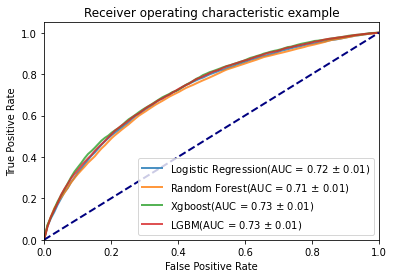

In [45]:
# Affichage de la courbe ROC pour les différents modèles testés en sous echantillonage
plot_roc_curve(classifiers_1, X_train_s1, y_train_s1)

### Utilisation de class_weight pour equilibrer les classes

In [46]:
X_train=pd.read_csv(path_data+"x_train.csv",index_col=0)
y_train=pd.read_csv(path_data+"y_train.csv",index_col=0)

In [47]:
X_train=X_train[feature_selected_list]
X_test=X_test[feature_selected_list]

In [83]:
feature_selected_list

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CREDIT_TO_ANNUITY_RATIO',
 'DAYS_BIRTH',
 'PROPORTION_LIFE_EMPLOYED',
 'CREDIT_TO_ANNUITY_RATIO_BY_AGE',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'INCOME_TO_ANNUITY_RATIO_BY_AGE',
 'AMT_ANNUITY',
 'INCOME_TO_ANNUITY_RATIO',
 'INCOME_TO_CREDIT_RATIO',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'AMT_GOODS_PRICE',
 'INCOME_TO_FAMILYSIZE_RATIO',
 'AMT_INCOME_TOTAL',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'CNT_FAM_MEMBERS',
 'AMT_REQ_CREDIT_BUREAU_QRT']

In [48]:
X_train_s1, X_train_s2, y_train_s1, y_train_s2 = train_test_split(X_train, y_train, test_size = 0.5, random_state = 42, stratify=y_train)

In [49]:
# Dictionnaire de classifieurs 
classifiers_2 = { 'Logistic Regression': LogisticRegression(class_weight='balanced'),
                  'Random Forest': RandomForestClassifier(n_estimators=100,class_weight='balanced'),
                  'Xgboost': XGBClassifier(class_weight='balanced'),
                  'LGBM': LGBMClassifier(class_weight='balanced')
              }

Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logi

Random Forest


/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:266: DataConversionWarning:

A column-vector y was p

Xgboost


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_labe

LGBM


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_labe

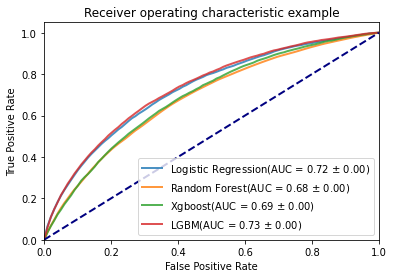

In [50]:
# Affichage de la courbe ROC pour les différents modèles testés class_weight
plot_roc_curve(classifiers_2, X_train_s1, y_train_s1)

meilleiur classifier: LGBM AUC=0.74

### Optimisation d'hyperparamètres

In [51]:
skf = StratifiedKFold(n_splits=5)
def model_v1(predictor, features, eval_metric, cv=skf):
    
    
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['TARGET'])
    
    # Extract feature names
    feature_names = list(features.columns)
    
    
    # Apply the pipeline
    # features = pipeline.fit_transform(features)
    targets = np.array(targets)    
    
    # Increase the data to get a bigger proportion of positif targets
    sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
    # to correspond to the pareto law with the 80%/20% ratio
    features_res, targets_res = sm.fit_resample(features, targets.ravel())  

    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
        }

        # asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score

 
    # possible values of parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
           'max_depth' : hp.quniform('max_depth', 2, 30, 2),
           'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
           'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
           'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
           'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
           'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }


    best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

    # computing the score on the test set
    predictor.set_params(
                   n_estimators=int(best['n_estimators']),
                   max_depth=int(best['max_depth']),
                   learning_rate=best['learning_rate'],
                   subsample=best['subsample'],           
                   colsample_bytree=best['colsample_by_tree'],
                   num_leaves=int(best['num_leaves']),
                   reg_alpha=best['reg_alpha'],
                   reg_lambda=best['reg_lambda'],
                    
    )
    
    # Entrainement du modèle sur tout le jeux de données
    predictor.fit(features, targets)

    # Record the best parameters
    best_parameters = best
    
    # Assemblage de pipeline
    full_pipeline = define_pipeline(predictor)
    full_pipeline.fit(features, targets)
    # full_pipeline = define_pipeline(pipeline, predictor)

    # Record the feature importances
    feature_importance_values = full_pipeline[-1].feature_importances_
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, full_pipeline

In [52]:
def Ind_bank(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [53]:
train_set=X_train.merge(y_train, how='inner', left_index=True, right_index=True)

In [54]:
train_set_s1,train_set_s2=train_test_split(train_set, test_size = 0.7, random_state = 42)

In [55]:
best_parameters_0, feature_importance_0, clf_0 = model_v1(LGBMClassifier(class_weight='balanced'),
                                                          train_set_s1,
                                                          eval_metric=Ind_bank)

100%|██████████| 10/10 [10:59<00:00, 65.99s/it, best loss: 0.24540597239977713]


In [56]:
best_parameters_0

{'colsample_by_tree': 0.6000000000000001,
 'learning_rate': 0.026478707430398492,
 'max_depth': 28.0,
 'n_estimators': 1000.0,
 'num_leaves': 4.0,
 'reg_alpha': 0.8,
 'reg_lambda': 0.7000000000000001,
 'solvability_threshold': 0.25,
 'subsample': 0.8}

In [57]:
# Sauvegarde du modèle banking
import pickle

pickle.dump(clf_0, open(path_data+'banking_model.md', 'wb'))

In [58]:
def gain_seuil(clf, y_set, x_set):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(Ind_bank(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

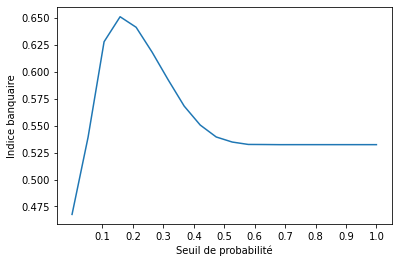

In [59]:
# Affiche le meilleur seuil de probabilité
gain_seuil(clf_0, y_val, X_val)

In [60]:
# Optimisation pour la métrique 'roc_auc'
best_parameters_1, feature_importance_1, clf_1 = model_v1(LGBMClassifier(class_weight='balanced'),
                                                          train_set_s1,
                                                          eval_metric=f1_score)

100%|██████████| 10/10 [10:21<00:00, 62.17s/it, best loss: 0.31695721077654515]


In [61]:
best_parameters_1

{'colsample_by_tree': 0.6000000000000001,
 'learning_rate': 0.03263542801105896,
 'max_depth': 18.0,
 'n_estimators': 1200.0,
 'num_leaves': 88.0,
 'reg_alpha': 0.7000000000000001,
 'reg_lambda': 0.9,
 'solvability_threshold': 0.5,
 'subsample': 0.8}

In [62]:
filename = 'banking_model_f1.md'
# Sauvegarde du modèle
pickle.dump(clf_1, open(path_data+filename, 'wb'))

### Comparaison des deux models

In [63]:
def plot_heatmap_confusion(y_valid, **y_valid_pred):
    
    plt.figure(1, figsize=(12, 4))
    results = {}
    
    j = 1
    for i, y_pred in y_valid_pred.items():
        
        plt.subplot(1, len(y_valid_pred), j)

        conf_mx = confusion_matrix(y_valid, y_pred)
        results[i] = conf_mx
        mat_conf_df = pd.DataFrame(conf_mx,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
        
        sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g')

        plt.title(i)
        plt.ylim(0, 2)
        plt.xlabel("Classes prédites")
        plt.ylabel("Classes réelles")
        j+=1
    plt.show()
    
    return results

In [64]:
y_proba_0 = clf_0.predict_proba(X_val)[:, 1]
y_pred_0 = (y_proba_0 > best_parameters_0['solvability_threshold'])
y_pred_0 = np.array(y_pred_0 > 0) * 1

In [65]:
y_proba_1 = clf_1.predict_proba(X_val)[:, 1]
y_pred_1 = (y_proba_1 > best_parameters_1['solvability_threshold'])
y_pred_1 = np.array(y_pred_1 > 0) * 1

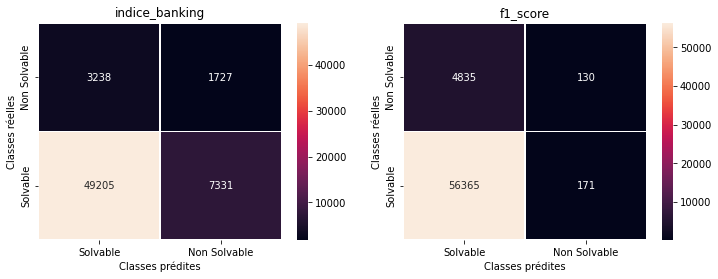

In [66]:
mat_conf = plot_heatmap_confusion(y_val,
                       **{"indice_banking": y_pred_0, "f1_score": y_pred_1})

les clients non solvables que nous detectons comme solvables sont aux nombre de 4916 en applicant le f1 score et 3924 en applicant l'indice bancaire

In [67]:
# Calcule du gain pour la métrique bancaire
J_0 = Ind_bank(y_val, y_pred_0)
# Calcul du gain pour la métrique métier
J_1 = Ind_bank(y_val, y_pred_1)
print("Le gain normalisé pour la métrique banking est de {:.2f} alors qu'il est de {:.2f} pour la métrique technique"
      .format(J_0, J_1))
print("La création de la métrique banking permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))

Le gain normalisé pour la métrique banking est de 0.63 alors qu'il est de 0.54 pour la métrique technique
La création de la métrique banking permet un gain de 13.3%


In [68]:
def calculate_multi_metrics(clf, x_valid, y_valid, threshold, *metrics):
   
    # liste des scores
    scores = []
    
    # calcule de la probabilité retourné par le modèle
    valid_proba = clf.predict_proba(x_valid)[:, 1]
    # calcule de la prédiction en fonction du threshold
    valid_predictions = (valid_proba > threshold)
    valid_predictions = np.array(valid_predictions > 0) * 1
    
    # Calcule le score pour chaque métrique
    for metric in metrics :
        scores.append(metric(y_valid, valid_predictions))
        
    return scores # retourne la liste des différents scores

In [69]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

In [70]:
scores_0=generate_model_report(y_val, y_pred_0)


Accuracy =  0.82814913578641
Precision =  0.19066018988739236
Recall =  0.3478348439073515
F1 Score =  0.246309634172431


In [71]:
scores_1=generate_model_report(y_val,y_pred_1)

Accuracy =  0.9186029495455359
Precision =  0.4318936877076412
Recall =  0.026183282980866064
F1 Score =  0.04937333839726547


In [72]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_0 = calculate_multi_metrics(clf_0,
                                   X_val,
                                   y_val,
                                   best_parameters_0["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

In [73]:
scores_1 = calculate_multi_metrics(clf_1,
                                   X_val,
                                   y_val,
                                   best_parameters_1["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

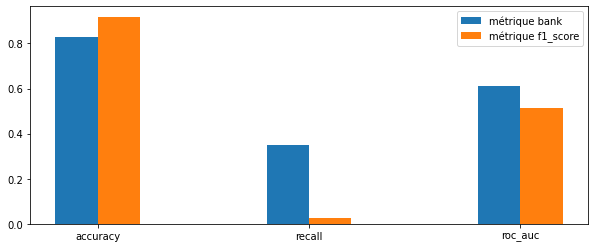

In [74]:
fig, ax = plt.subplots(1, figsize=(10, 4))

x = np.arange(3)  # the label locations
width = 0.2  # the width of the bars

ax.bar(x - width/2, scores_0, width, label='métrique bank')

ax.bar(x + width/2, scores_1, width, label='métrique f1_score')

ax.set_xticks(x)
ax.set_xticklabels(['accuracy', 'recall', 'roc_auc'])
ax.legend()
plt.show()

remplacer l'accuracy par la precision

### Importances des variables

In [75]:
def plot_feature_importances(df):
        
    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 4))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:10]))), 
            df['importance_normalized'].head(10), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:10]))))
    ax.set_yticklabels(df['feature'].head(10))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    


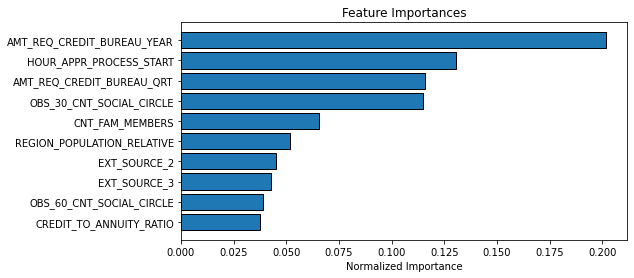

In [76]:
# Affichage des 10 variables les plus importance
plot_feature_importances(feature_importance_0)

In [77]:
!pip install shap

     |████████████████████████████████| 564 kB 8.1 MB/s 


In [78]:
import shap

In [79]:
X_1=data_1[feature_selected_list].sample(1000)

In [80]:
explainer = shap.Explainer(clf_0.predict, X_1) #rfr_search.best_estimator_
shap_values = explainer(X_1)

Permutation explainer: 1001it [27:01,  1.63s/it]


In [82]:
explainer = shap.Explainer(clf_0.predict, X_1) #rfr_search.best_estimator_
shap_values = explainer(X_1)

Permutation explainer: 1001it [26:56,  1.63s/it]


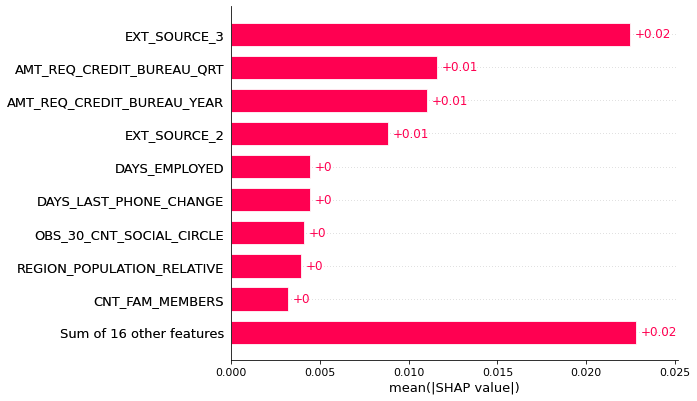

In [84]:
shap.plots.bar(shap_values)

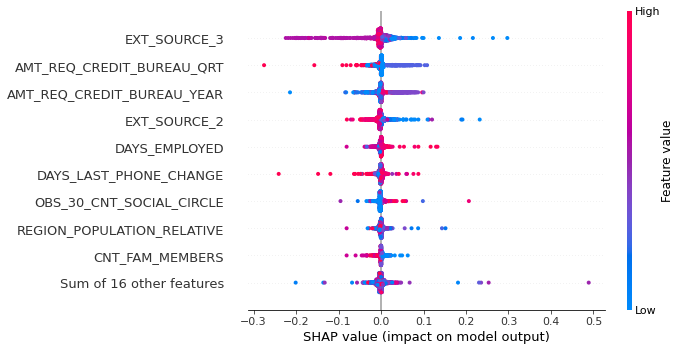

In [85]:
shap.plots.beeswarm(shap_values)

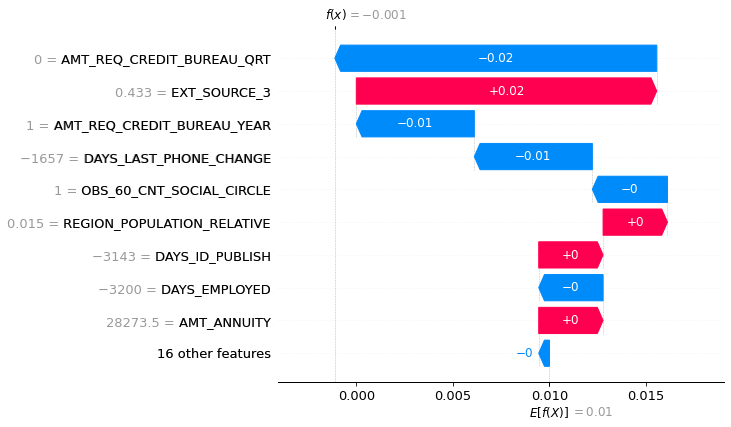

In [86]:
shap.plots.waterfall(shap_values[10], max_display=10)

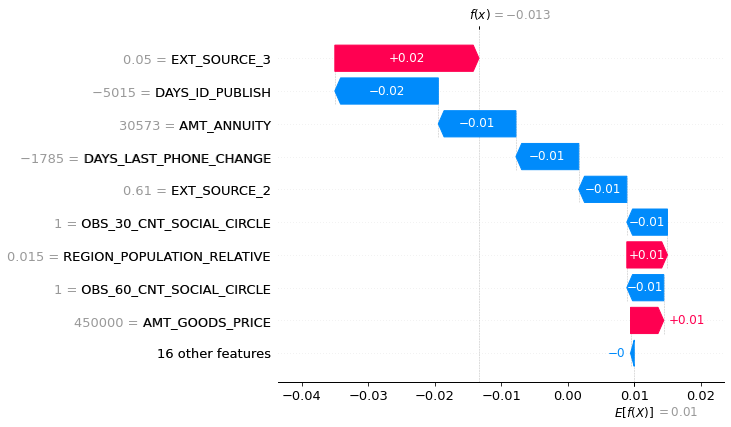

In [108]:
shap.plots.waterfall(shap_values[15], max_display=10)

In [103]:
y_train.iloc[1005]

TARGET    1
Name: 199149, dtype: int64